Neural Network Tuning and Training
by Pasquale Napoli

Questa colonna assicura che tutti i file siano presenti se il codice è lanciato su colab

In [ ]:
import sys
from pathlib import Path
if "google.colab" in sys.modules:
    print("Colab Detected")
    import tensorflow as tf
    gpus = tf.config.list_physical_devices("GPU")
    if not gpus:
        raise RuntimeError("Nessuna GPU trovata.Controlla di aver selezionato il runtime giusto.")
    else:
        print(f"Trovate {len(gpus)} GPU:\n{gpus}")
    
    !git clone https://github.com/AtomicDonuts/Progetto_Computings.git
    %cd Progetto_Computings/
    !pip install -q -r requirements.txt
    !python3 fits_import/fits2csv.py

    git_dir = None
    for i in Path(__file__).parents:
        for j in i.iterdir():
            if ".git" in j.as_posix() and j.is_dir():
                git_dir = i
    if git_dir is None:
        raise FileNotFoundError(
            "Git Directory Not Found. Please ensure that you cloned the repository in the right way."
        )
    import_dir = git_dir / "imports/"
    sys.path.append(import_dir.as_posix())
    import nn_models as ann
    import custom_variables as custom_paths
    import metrics as met
else:
    git_dir = None
    for i in Path(__file__).parents:
        for j in i.iterdir():
            if ".git" in j.as_posix() and j.is_dir():
                git_dir = i
    if git_dir is None:
        raise FileNotFoundError(
            "Git Directory Not Found. Please ensure that you cloned the repository in the right way."
        )
    import_dir = git_dir / "imports/"
    sys.path.append(import_dir.as_posix())
    import nn_models as ann
    import custom_variables as custom_paths
    import metrics as met

In [ ]:
from loguru import logger
import numpy as np
import pandas as pd
import keras
from keras.models import clone_model
import keras_tuner as kt
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Importazione del Database

In [ ]:
df = pd.read_csv(custom_paths.csv_path)
df = df[(df["CLASS_GENERIC"] == "AGN") | (df["CLASS_GENERIC"] == "Pulsar")]
print(f"Sample Size: {len(df)}")

Poi si scelgono le colonne che vogliamo usare nell'addestramento

In [ ]:
col_input1 = ["GLAT","Variability_Index" ,"PowerLaw","LogParabola","PLSuperExpCutoff"]
col_flux_band = np.array([[f"Flux_Band_{i}", f"Sqrt_TS_Band_{i}"] for i in range(8)])
col_flux_hist = np.array([[f"Flux_History_{i}", f"Sqrt_TS_History_{i}"] for i in range(14)])

Normalizziamo le colonne usando lo scaler, in modo che abbiano media = 0 e sigma = 1

In [ ]:
norm_cols = np.array(list(col_flux_band.flatten()) + list(col_flux_hist.flatten()))
scaler = StandardScaler()
scaler.fit(df[norm_cols])
scaled_data = scaler.transform(df[norm_cols])
df[norm_cols] = scaled_data

Definiamo quindi gli array per l'addestramento

In [ ]:
input_additional = df[col_input1].to_numpy()
input_flux_band = df[col_flux_band.flatten()].to_numpy()
input_flux_hist = df[col_flux_hist.flatten()].to_numpy()
print(f"Additionl Size: {input_additional.shape}")
print(f"Flux_Band Size: {input_flux_band.shape}")
print(f"Flux_History Size: {input_flux_hist.shape}")

Creazione delle label, scegliendo "Pulsar" come Vero Positivo (1) e "AGN" come Vero Negativo (0)

In [ ]:
is_agn = df["CLASS_GENERIC"].to_numpy() == "AGN"
labels = np.zeros((len(df)), dtype=int)
labels[~is_agn] = 1

Dato che la distribuzione delle due classi è sbilanciate, 4000 AGN vs 300 Pulsar, creiamo dei pesi da dare al tuner, in modo da migliorare l'addestramento.

In [ ]:
class_weight = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(labels), y=labels
)
class_weight = {index: value for index, value in enumerate(class_weight)}

Splittiamo il dataset in 75%-25%, dove il 25% verrà usato alla fine per l'inferenza
Lo split è fatto usando la fuznione dello StratifiedKFold, in questo modo assicuriamo un uguale rapporto di classi in entrambi i dataset.

In [ ]:
splitdata = StratifiedKFold(n_splits=4, shuffle=True)
train, test = next(splitdata.split(np.zeros(len(labels)), labels))

fb = input_flux_band[train]
hb = input_flux_hist[train]
ia = input_additional[train]
lab = labels[train]
vfb =  input_flux_band[test]
vhb =  input_flux_hist[test]
via = input_additional[test]
vlab = labels[test]

Definiamo i parametri della ricerca per il Tuner e lo facciamo partire.

In [ ]:
tuner = kt.Hyperband(
    ann.hp_final_model,
    objective="val_loss",
    max_epochs=100,
    factor=3,
    overwrite=False,
    directory="Progetto",
    project_name="TripleInput",
)
stop_early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
tuner.search(
    x=[fb, hb, ia],
    y=lab,
    epochs=50,
    validation_split=0.5,
    class_weight=class_weight,
    callbacks=[stop_early],
)

Prendiamo il miglior modello trovato dal tuner (quello con la validation loss minore) e ne salviamo il learning rate

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_lr = best_model.optimizer.learning_rate

Definiamo una serie di array in cui verranno immagazzinate le metriche

In [15]:
history_arrya = []

loss_k_array = []
auc_k_array = []
accuracy_k_array = []
acc_agn_k_array = []
acc_psr_k_array = []
eq_th_k_array =[]
eq_acc_agn_k_array = []
eq_acc_psr_k_array = []
f1_k_array = []
th_k_array = []
cm_k_array = []

loss_all_array = []
auc_all_array = []
accuracy_all_array = []
acc_agn_all_array = []
acc_psr_all_array = []
eq_th_all_array = []
eq_acc_agn_all_array = []
eq_acc_psr_all_array = []
f1_all_array = []
th_all_array = []
cm_all_array = []

Si esegue lo Stratified 10 Fold sul modello migliore di iperparametri, ma resettando i pesi a valori casuali.
Il learning rate però rimane lo stesso trovato prima. 
Le metriche vengono salvate negli array, in modo tale da poterne fare la media e l'errore.

In [16]:
fold_no = 0
skf = StratifiedKFold(n_splits=10, shuffle=True)
for ktrain, ktest in skf.split(np.zeros(len(lab)), lab):
    k_hb   = hb[ktrain]
    k_fb   = fb[ktrain]
    k_ia   = ia[ktrain]
    k_lab  = lab[ktrain]
    k_vfb  =  fb[ktest]
    k_vhb  =  hb[ktest]
    k_via  =  ia[ktest]
    k_vlab = lab[ktest]

    reset_model = clone_model(best_model)
    reset_model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            "auc",
        ],
    )
    reset_model.optimizer.learning_rate = best_lr

    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)

    history = reset_model.fit(
        x=[k_fb, k_hb, k_ia],
        y=k_lab,
        epochs=300,
        validation_data=[[k_vfb, k_vhb, k_via], k_vlab],
        callbacks=[early_stopping, reduce_lr]
    )

    history_array.append(history)

    print(f"Fold No.{fold_no}")
    print("------------------------------------------------------------------------")
    print("Prediction on Fold")
    scores = reset_model.evaluate([k_vfb, k_vhb, k_via], k_vlab)
    predictions = reset_model.predict([k_vfb, k_vhb, k_via])

    loss_k_array.append(scores[0])
    auc_k_array.append(scores[1])
    print(f"Loss: {scores[0]}")
    print(f"AUC {scores[2]}")

    acc, th = met.best_accuracy(k_vlab, predictions)
    accuracy_k_array.append(acc)
    th_k_array.append(th)
    print(f"Accuracy: {acc}")

    f1_score = met.f1_score(th,k_vlab, predictions)
    f1_k_array.append(f1_score)
    print(f"F1 Score: {f1_score}")

    eq_acc_agn,eq_acc_psr, eq_th = met.best_eq_accuracy(k_vlab, predictions)
    eq_th_k_array.append(eq_th)
    eq_acc_agn_k_array.append(eq_acc_agn)
    eq_acc_psr_k_array.append(eq_acc_psr)
    print(f"EqAcc AGN: {eq_acc_agn}")
    print(f"EqAcc PSR: {eq_acc_psr}")

    acc_agn, acc_psr = met.class_accuracy(th, k_vlab, predictions)
    acc_agn_k_array.append(acc_agn)
    acc_psr_k_array.append(acc_psr)
    print(f"Accuracy AGN: {acc_agn} Accuracy PSR: {acc_psr}")

    th_pred = (predictions >= th).astype(int)
    cm_sing = met.sk_metrics.confusion_matrix(k_vlab, th_pred)
    print(cm_sing)
    cm_k_array.append(cm_sing)

    print("------------------------------------------------------------------------")

    print("Prediction on Evaluation Dataset")
    scores = reset_model.evaluate([vfb, vhb, via], vlab)
    predictions = reset_model.predict([vfb, vhb, via])

    loss_all_array.append(scores[0])
    auc_all_array.append(scores[1])
    print(f"Loss: {scores[0]}")
    print(f"AUC {scores[2]}")

    acc, th = met.best_accuracy(vlab, predictions)
    accuracy_all_array.append(acc)
    th_all_array.append(th)
    print(f"Accuracy: {acc}")

    f1_score = met.f1_score(th, vlab, predictions)
    f1_all_array.append(f1_score)
    print(f"F1 Score: {f1_score}")

    eq_acc_agn,eq_acc_psr, eq_th = met.best_eq_accuracy(vlab, predictions)
    eq_th_all_array.append(eq_th)
    eq_acc_agn_all_array.append(eq_acc_agn)
    eq_acc_psr_all_array.append(eq_acc_psr)
    print(f"EqAcc AGN: {eq_acc_agn}")
    print(f"EqAcc PSR: {eq_acc_psr}")

    acc_agn, acc_psr = met.class_accuracy(th, vlab, predictions)
    acc_agn_all_array.append(acc_agn)
    acc_psr_all_array.append(acc_psr)
    print(f"Accuracy AGN: {acc_agn} Accuracy PSR: {acc_psr}")

    th_pred = (predictions >= th).astype(int)
    cm_sing = met.sk_metrics.confusion_matrix(vlab, th_pred)
    print(cm_sing)
    cm_all_array.append(cm_sing)
    print("------------------------------------------------------------------------")

    modelpath = custom_paths.dir_models_path / f"TripleFolf{fold_no}.keras"
    reset_model.save(modelpath)

    fold_no = fold_no + 1
# end for
cm_k_array = np.array(cm_k_array)
cm_all_array = np.array(cm_all_array)

Epoch 1/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.9050 - auc: 0.7595 - loss: 0.2819 - val_accuracy: 0.9262 - val_auc: 0.9812 - val_loss: 0.1160 - learning_rate: 0.0093
Epoch 2/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9451 - auc: 0.9495 - loss: 0.1313 - val_accuracy: 0.9631 - val_auc: 0.9885 - val_loss: 0.0950 - learning_rate: 0.0093
Epoch 3/300
92/92 ━━━━━━━━━━━━━━━━━━━━ -1s 10ms/step - accuracy: 0.9768 - auc: 0.9701 - loss: 0.0897 - val_accuracy: 0.9631 - val_auc: 0.9896 - val_loss: 0.0740 - learning_rate: 0.0093
Epoch 4/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9751 - auc: 0.9598 - loss: 0.0920 - val_accuracy: 0.9662 - val_auc: 0.9893 - val_loss: 0.0773 - learning_rate: 0.0093
Epoch 5/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9700 - auc: 0.9682 - loss: 0.1030 - val_accuracy: 0.9662 - val_auc: 0.9883 - val_loss: 0.0758 - learning_rate: 0.0093
Epoch 6/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9764 - auc: 0.96

Print di tutte i valori delle metriche trovate.
Viene anche detto qual è il migliore tra i 10 modelli allenati.
Quello verrà utilizzato per l'inferenza nello script prediction.py

In [17]:
print(f"Best Model Was: {np.argmax(f1_all_array)}. Based on F1Score")
print("------------------------------------------------------------------------\n")
print("Average scores for all folds:")
print("Prediction on Fold")
print(f"> Loss: {np.mean(loss_k_array)}(+- {np.std(loss_k_array)})")
print(f"> AUC: {np.mean(auc_k_array)} (+- {np.std(auc_k_array)})")
print(f"> Accuracy: {np.mean(accuracy_k_array)} (+- {np.std(accuracy_k_array)})")
print(f"> F1: {np.mean(f1_k_array)} (+- {np.std(f1_k_array)})")
print(f"> EqAcc AGN: {np.mean(eq_acc_agn_k_array)} (+- {np.std(eq_acc_agn_k_array)})")
print(f"> EqAcc PSR: {np.mean(eq_acc_psr_k_array)} (+- {np.std(eq_acc_psr_k_array)})")
print(f"> Acc AGN: {np.mean(acc_agn_k_array)} (+- {np.std(acc_agn_k_array)})")
print(f"> Acc PSR: {np.mean(acc_psr_k_array)} (+- {np.std(acc_psr_k_array)})")
print("Confution Matrix")
print(f"{np.mean(cm_k_array[:,0,0])}+-{np.std(cm_k_array[:,0,0])}\t{np.mean(cm_k_array[:,0,1])}+-{np.std(cm_k_array[:,0,1])}")
print(f"{np.mean(cm_k_array[:,1,0])}+-{np.std(cm_k_array[:,1,0])}\t{np.mean(cm_k_array[:,1,1])}+-{np.std(cm_k_array[:,1,1])}")
print("--------------------------------------------------------")
print("Prediction on Evaluation DataSet")
print(f"> Loss: {np.mean(loss_all_array)}(+- {np.std(loss_all_array)})")
print(f"> AUC: {np.mean(auc_all_array)} (+- {np.std(auc_all_array)})")
print(f"> Accuracy: {np.mean(accuracy_all_array)} (+- {np.std(accuracy_all_array)})")
print(f"> F1: {np.mean(f1_all_array)} (+- {np.std(f1_all_array)})")
print(f"> EqAcc AGN: {np.mean(eq_acc_agn_all_array)} (+- {np.std(eq_acc_agn_all_array)})")
print(f"> EqAcc PSR: {np.mean(eq_acc_psr_all_array)} (+- {np.std(eq_acc_psr_all_array)})")
print(f"> Acc AGN: {np.mean(acc_agn_all_array)} (+- {np.std(acc_agn_all_array)})")
print(f"> Acc PSR: {np.mean(acc_psr_all_array)} (+- {np.std(acc_psr_all_array)})")
print("Confution Matrix")
print(f"{np.mean(cm_all_array[:,0,0])}+-{np.std(cm_all_array[:,0,0])}\t{np.mean(cm_all_array[:,0,1])}+-{np.std(cm_all_array[:,0,1])}")
print(f"{np.mean(cm_all_array[:,1,0])}+-{np.std(cm_all_array[:,1,0])}\t{np.mean(cm_all_array[:,1,1])}+-{np.std(cm_all_array[:,1,1])}")
print("------------------------------------------------------------------------")


Best Model Was: 6. Based on F1Score
------------------------------------------------------------------------

Average scores for all folds:
Prediction on Fold
> Loss: 0.04217293541878462(+- 0.014495313956040173)
> AUC: 0.9861538529396057 (+- 0.006037350475321916)
> Accuracy: 0.9886153846153846 (+- 0.004776669137310752)
> F1: 0.9169930739935366 (+- 0.03769615602413919)
> EqAcc AGN: 0.9524916943521596 (+- 0.02015655988321265)
> EqAcc PSR: 0.9541666666666668 (+- 0.022438186696393785)
> Acc AGN: 0.9983388704318937 (+- 0.002228639180232363)
> Acc PSR: 0.8666666666666666 (+- 0.0692218655243173)
Confution Matrix
300.5+-0.6708203932499369	0.5+-0.6708203932499369
3.2+-1.6613247725836149	20.8+-1.661324772583615
--------------------------------------------------------
Prediction on Evaluation DataSet
> Loss: 0.03091989513486624(+- 0.0017726276463208884)
> AUC: 0.9888376235961914 (+- 0.00133365300919059)
> Accuracy: 0.9913284132841328 (+- 0.0009407785080429451)
> F1: 0.9391099955381103 (+- 0.00664

In [18]:
import matplotlib.pyplot as plt

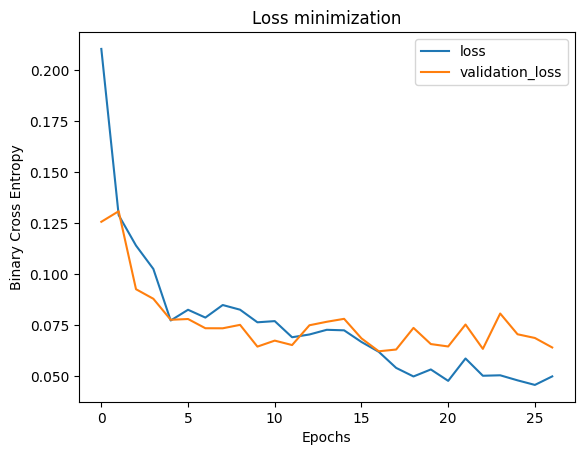

In [28]:
plt.plot(history_array[0].history["loss"],label = "loss")
plt.plot(history_array[0].history["val_loss"],label = "validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy")
plt.title("Loss minimization")
plt.legend()
plt.savefig("Loss.png")
plt.show()

In [38]:
lossh = []
vlossh = []
for i in history_array:
    lossh.append(i.history["loss"])
    vlossh.append(i.history["val_loss"])

In [49]:
max_loss = np.array([len(h) for h in lossh]).max()
max_vloss = np.array([len(h) for h in vlossh]).max()

In [50]:
for l in lossh:
    if len(l) < max_loss:
        for i in range(max_loss - len(l)):
            l.append(0)
lossh = np.array(lossh)

In [51]:
for l in vlossh:
    if len(l) < max_vloss:
        for i in range(max_vloss - len(l)):
            l.append(0)
vlossh = np.array(vlossh)

In [53]:
np.mean(lossh,axis = 0)

array([0.21902453, 0.13041375, 0.10689524, 0.09402904, 0.0877998 ,
       0.08021476, 0.07997609, 0.07831258, 0.07347396, 0.07041797,
       0.06581317, 0.06251259, 0.06387686, 0.06310529, 0.0595952 ,
       0.06210668, 0.05780387, 0.05642446, 0.05832051, 0.05310778,
       0.05034529, 0.05265715, 0.04254351, 0.0410228 , 0.0391923 ,
       0.03873717, 0.02966657, 0.02090425, 0.0172249 , 0.01829139,
       0.01680447, 0.01631402, 0.01949255, 0.01286964, 0.01392895,
       0.01247133, 0.01155403, 0.01219762, 0.00373068, 0.0033445 ,
       0.00352612])

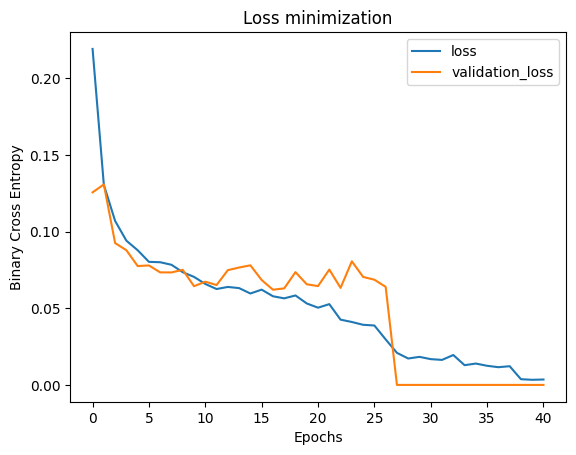

In [54]:
plt.plot(np.mean(lossh, axis=0), label="loss")
plt.plot(history_array[0].history["val_loss"], label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy")
plt.title("Loss minimization")
plt.legend()
plt.savefig("Loss.png")
plt.show()

In [69]:
dataframe = pd.read_csv(custom_paths.csv_path)

In [73]:
a = dataframe[dataframe["CLASS_GENERIC"] == "No Association"]["CLASS_DNN"]

In [81]:
(len(a[a=="AGN"])/len(a) * 100)

94.84110606685927

In [82]:
(1 - len(a[a == "AGN"]) / len(a) )* 100

5.158893933140729